In [1]:
from transformers import AutoModel
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from transformers import DataCollatorWithPadding
import gc

from accelerate import Accelerator

import os
os.environ["TOKENIZERS_PARALLELISM"] = 'false'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Config

In [2]:
config = {
    'model' : 'model',
    'tokenizer' : 'tokenizer',
    'dropout' : 0.1,
    'max_length' : 512,
    'batch_size' : 8,
    'epochs' : 100,
    'lr' : 2e-7,
    'enable_scheduler' : True,
    'scheduler' : 'CosineAnnealingWarmRestarts',
    'gradient_accumulation_steps' : 4,
    'adam_eps' : 1e-6,
    'freeze_encoder' : False,
    'trn_fold': [0, 1, 2, 3],
    'target_cols' : ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions'],
    'lr_patience' : 12,
}

# Tokenizer

In [3]:
tokenizer = torch.load('../input/save-tokenizer/delarge_tokenizer.pt')

In [4]:
df = pd.read_csv('../input/feedback-prize-english-language-learning/train.csv')#.iloc[:100,:]
test_df = pd.read_csv('../input/feedback-prize-english-language-learning/test.csv')
print('Train DataFrame:', df.shape, 'Test DataFrame:', test_df.shape)
print('Train columns name:',df.columns.to_list())

Train DataFrame: (3911, 8) Test DataFrame: (3, 2)
Train columns name: ['text_id', 'full_text', 'cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']


# Dataset

In [5]:
class Dataset: 
    def __init__(self, df, config, tokenizer=None, is_test=False):
        self.df = df.reset_index(drop=True)
        self.classes = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
        self.max_len = config['max_length']
        self.tokenizer = tokenizer
        self.is_test = is_test
    def __getitem__(self, idx):
        sample = self.df['full_text'][idx]
        tokenized = tokenizer.encode_plus(sample,
                                         None,
                                         add_special_tokens=True,
                                         max_length = self.max_len,
                                         truncation=True,
                                         padding='max_length')
        inputs = {
            'input_ids' : torch.tensor(tokenized['input_ids'], dtype=torch.long),
            'token_type_ids' : torch.tensor(tokenized['token_type_ids'], dtype=torch.long),
            'attention_mask' : torch.tensor(tokenized['attention_mask'], dtype=torch.long)
        }
        
        if self.is_test == True:
            return inputs
        
        label = self.df.loc[idx, self.classes].to_list()
        targets = {
            "labels" : torch.tensor(label, dtype=torch.float32),
        }
        
        return inputs, targets
    
    def __len__(self):
        return len(self.df)

# train_test_split

In [6]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=1357, shuffle=True)
print('Dataframe shapes :', train_df.shape, val_df.shape)

Dataframe shapes : (3128, 8) (783, 8)


# DataLoader

In [7]:
train_ds = Dataset(train_df, config, tokenizer=tokenizer)
val_ds = Dataset(val_df, config, tokenizer=tokenizer)
test_ds = Dataset(test_df, config, tokenizer=tokenizer, is_test=True)

In [8]:
train_ds[0][0].keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [9]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=config['batch_size'], shuffle=True, num_workers=2, pin_memory=True)

In [10]:
print('loader shapes:',len(train_loader), len(val_loader))

loader shapes: 391 98


# Pooling

In [11]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

# Model

In [12]:
class DebertaModel(nn.Module):
    def __init__(self, config, num_classes=6):
        super(DebertaModel, self).__init__()
        self.freeze = config['freeze_encoder']
        
        self.encoder = torch.load('../input/save-tokenizer/delarge_model_model.pt')
        if self.freeze:
            for param in self.encoder.base_model.parameters():
                param.requires_grad = False
                
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(config['dropout'])
        self.fc1 = nn.Linear(self.encoder.config.hidden_size, 64)
        self.fc2 = nn.Linear(64, num_classes)
        
    def forward(self, inputs):
        outputs = self.encoder(**inputs, return_dict=True)
        outputs = self.pooler(outputs['last_hidden_state'], inputs['attention_mask'])
        outputs = self.fc1(outputs)
        outputs = self.fc2(outputs)
        return outputs

In [13]:
# import EarlyStopping
# from pytorchtools import EarlyStopping
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# Trainer

In [14]:
class Trainer:
    def __init__(self, model, loaders, config, accelerator):
        self.model = model
        self.train_loader , self.val_loader = loaders
        self.config = config
        self.input_keys = ['input_ids', 'token_type_ids', 'attention_mask']
        self.accelerator = accelerator
        self.optim = self._get_optim()
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optim, T_0=5, eta_min = 1e-7)
        self.train_losses = []
        self.val_losses = []

    def prepare(self):
        self.model, self.optim, self.train_loader, self.val_loader, self.schduler = self.accelerator.prepare(
            self.model,
            self.optim,
            self.train_loader,
            self.val_loader,
            self.scheduler
        )
    def _get_optim(self):
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters=[
            {'params': [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
            {'params': [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
        optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=self.config['lr'], eps=self.config['adam_eps'])
        return optimizer
    
    def loss_fn(self, outputs, targets):
        colwise_mse = torch.mean(torch.square(targets - outputs), dim=0)
        loss = torch.mean(torch.sqrt(colwise_mse), dim=0)
        return loss
    
    def train_one_epoch(self,epoch):
        running_loss = 0.
        progress = tqdm(self.train_loader, total=len(self.train_loader))
        
        for idx, (inputs, targets) in enumerate(progress):
            with self.accelerator.accumulate(self.model):
                outputs = self.model(inputs)
                loss = self.loss_fn(outputs, targets['labels'])
                running_loss += loss.item()
                
                self.accelerator.backward(loss)
                
                self.optim.step()
                
                if self.config['enable_scheduler']:
                    self.scheduler.step(epoch-1 + idx / len(self.train_loader))
                
                self.optim.zero_grad()
                
                del inputs, targets, outputs, loss
                
        train_loss = running_loss/len(self.train_loader)
        self.train_losses.append(train_loss)
        
    @torch.no_grad()
    def valid_one_epoch(self, epoch):
        running_loss = 0.
        progress = tqdm(self.val_loader, total=len(self.val_loader))
        for (inputs, targets) in progress:
            outputs = self.model(inputs)
            loss = self.loss_fn(outputs, targets['labels'])
            running_loss += loss.item()
            self.accelerator.backward(loss)
            self.optim.step()
            
            if self.config['enable_scheduler']:
                self.sheduler.step(epoch -1 + idx/len(self.train_loader))
                
            self.optim.zero_grad()
            
            del inputs, targets, outputs, loss
            
        train_loss = running_loss/len(self.train_loader)
        self.train_losses.append(train_loss)
        
    @torch.no_grad()
    def valid_one_epoch(self,epoch):
        running_loss = 0.
        progress = tqdm(self.val_loader, total = len(self.val_loader))
        
        for (inputs, targets) in progress:
            outputs = self.model(inputs)
            loss = self.loss_fn(outputs, targets['labels'])
            running_loss += loss.item()
            del inputs, targets, outputs, loss
            
        val_loss = running_loss/len(self.val_loader)
        self.val_losses.append(val_loss)
        

    def test(self, test_loader):
        
        preds = []
        for (inputs) in test_loader:
            outputs = self.model(inputs)
            preds.append(outputs.detach().cpu())
            
        preds = torch.concat(preds)
        return preds
    
    def fit(self):
        self.prepare()
        fit_progress = tqdm(
            range(1, self.config['epochs']+1),
            leave = True,
            desc = "Training..."
        )
        self.early_stopping = EarlyStopping(patience = self.config['lr_patience'], verbose = True)

        for epoch in fit_progress:
            self.model.train()
            fit_progress.set_description(f"EPOCH {epoch} / {self.config['epochs']} | training...")
            self.train_one_epoch(epoch)
            self.clear()
            
            self.model.eval()
            fit_progress.set_description(f"EPOCH {epoch} / {self.config['epochs']} | validating...")
            self.valid_one_epoch(epoch)
            self.clear()

            print(f"{'➖️'*10} EPOCH {epoch} / {self.config['epochs']} {'➖️'*10}")
            print(f"train loss: {self.train_losses[-1]}")
            print(f"valid loss: {self.val_losses[-1]}\n\n")

            self.early_stopping(self.val_losses[-1], self.model)
            
            if self.early_stopping.early_stop:
              print("Early stopping")
              break
            
    def get_model(self):
        # best model이 저장되어있는 last checkpoint를 로드한다.
        self.model.load_state_dict(torch.load('checkpoint.pt'))

        return self.model
            
    def clear(self):
        gc.collect()
        torch.cuda.empty_cache()


# Accelerate

In [15]:
accelerator = Accelerator(gradient_accumulation_steps=config['gradient_accumulation_steps'])

In [16]:
model = DebertaModel(config).to(device=accelerator.device)
trainer = Trainer(model, (train_loader, val_loader), config, accelerator)

In [17]:
trainer.fit()

Training...:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 1 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 3.028625987679757
valid loss: 2.96831996586858


Validation loss decreased (inf --> 2.968320).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 2 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 2.93051254048067
valid loss: 2.869708080681003


Validation loss decreased (2.968320 --> 2.869708).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 3 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 2.8288838576782696
valid loss: 2.7641091663010267


Validation loss decreased (2.869708 --> 2.764109).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 4 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 2.7113958880724502
valid loss: 2.6403186856483924


Validation loss decreased (2.764109 --> 2.640319).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 5 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 2.5756649916129346
valid loss: 2.4940908709350897


Validation loss decreased (2.640319 --> 2.494091).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 6 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 2.302107360052026
valid loss: 2.038692012125132


Validation loss decreased (2.494091 --> 2.038692).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 7 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 1.8803009261255679
valid loss: 1.6427844166755676


Validation loss decreased (2.038692 --> 1.642784).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 8 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 1.6126776799521483
valid loss: 1.4233261407638083


Validation loss decreased (1.642784 --> 1.423326).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 9 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 1.457874815787196
valid loss: 1.300809492870253


Validation loss decreased (1.423326 --> 1.300809).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 10 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 1.3610696820042016
valid loss: 1.2166896979419553


Validation loss decreased (1.300809 --> 1.216690).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 11 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 1.2590890352988182
valid loss: 1.0913646507019898


Validation loss decreased (1.216690 --> 1.091365).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 12 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 1.156646296038957
valid loss: 1.0012168507186734


Validation loss decreased (1.091365 --> 1.001217).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 13 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 1.085427554824468
valid loss: 0.9468529729210601


Validation loss decreased (1.001217 --> 0.946853).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 14 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 1.0356363850786252
valid loss: 0.9104460356186848


Validation loss decreased (0.946853 --> 0.910446).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 15 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 1.0012348922317291
valid loss: 0.8788156278279363


Validation loss decreased (0.910446 --> 0.878816).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 16 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.958321078506577
valid loss: 0.8300033150887003


Validation loss decreased (0.878816 --> 0.830003).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 17 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.9130694155802812
valid loss: 0.7968401775068167


Validation loss decreased (0.830003 --> 0.796840).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 18 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.8770921976517534
valid loss: 0.7679190933704376


Validation loss decreased (0.796840 --> 0.767919).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 19 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.8527892244898755
valid loss: 0.7519655245907453


Validation loss decreased (0.767919 --> 0.751966).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 20 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.8335759987306717
valid loss: 0.7357637912643199


Validation loss decreased (0.751966 --> 0.735764).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 21 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.8104709706190601
valid loss: 0.7111945325622753


Validation loss decreased (0.735764 --> 0.711195).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 22 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.7848436042018558
valid loss: 0.6988203005523098


Validation loss decreased (0.711195 --> 0.698820).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 23 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.7654497949668514
valid loss: 0.6845530028245888


Validation loss decreased (0.698820 --> 0.684553).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 24 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.7497542675803689
valid loss: 0.6762028972105104


Validation loss decreased (0.684553 --> 0.676203).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 25 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.7374566576212568
valid loss: 0.6708839280264718


Validation loss decreased (0.676203 --> 0.670884).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 26 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.7267370257536163
valid loss: 0.6640173035616778


Validation loss decreased (0.670884 --> 0.664017).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 27 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.7085064647295286
valid loss: 0.6511683248135508


Validation loss decreased (0.664017 --> 0.651168).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 28 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.6953613453966272
valid loss: 0.6455636483674146


Validation loss decreased (0.651168 --> 0.645564).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 29 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.6836675574712436
valid loss: 0.6426024072024287


Validation loss decreased (0.645564 --> 0.642602).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 30 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.6736058504380229
valid loss: 0.6404275498828109


Validation loss decreased (0.642602 --> 0.640428).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 31 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.6628189364357677
valid loss: 0.6335293681037669


Validation loss decreased (0.640428 --> 0.633529).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 32 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.6509672396475702
valid loss: 0.6100689759668039


Validation loss decreased (0.633529 --> 0.610069).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 33 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.6398354744362404
valid loss: 0.6184619266767891


EarlyStopping counter: 1 out of 12


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 34 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.6329901437930134
valid loss: 0.6036662322526075


Validation loss decreased (0.610069 --> 0.603666).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 35 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.6258272501208898
valid loss: 0.611700679574694


EarlyStopping counter: 1 out of 12


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 36 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.6182898213643857
valid loss: 0.6126348400602535


EarlyStopping counter: 2 out of 12


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 37 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.6082049253041787
valid loss: 0.5973696602242333


Validation loss decreased (0.603666 --> 0.597370).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 38 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.601168716655058
valid loss: 0.5991023480892181


EarlyStopping counter: 1 out of 12


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 39 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.5950736406514102
valid loss: 0.6074832069630526


EarlyStopping counter: 2 out of 12


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 40 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.5903834864459074
valid loss: 0.6008327332686405


EarlyStopping counter: 3 out of 12


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 41 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.5858930087912723
valid loss: 0.6009978956105758


EarlyStopping counter: 4 out of 12


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 42 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.5786658830350012
valid loss: 0.5901629635874106


Validation loss decreased (0.597370 --> 0.590163).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 43 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.5732389551294429
valid loss: 0.5837858669003662


Validation loss decreased (0.590163 --> 0.583786).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 44 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.5672079130359318
valid loss: 0.5982768553860334


EarlyStopping counter: 1 out of 12


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 45 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.5653801765435796
valid loss: 0.5794322064944676


Validation loss decreased (0.583786 --> 0.579432).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 46 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.5617645509407648
valid loss: 0.5928153879180247


EarlyStopping counter: 1 out of 12


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 47 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.5555057710851244
valid loss: 0.5814823313635222


EarlyStopping counter: 2 out of 12


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 48 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.5506625783717846
valid loss: 0.5857972177315731


EarlyStopping counter: 3 out of 12


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 49 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.5467183115842092
valid loss: 0.5774705349182596


Validation loss decreased (0.579432 --> 0.577471).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 50 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.5442835382945702
valid loss: 0.5770451913074571


Validation loss decreased (0.577471 --> 0.577045).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 51 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.5415836696886955
valid loss: 0.5808945702654975


EarlyStopping counter: 1 out of 12


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 52 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.5368029828114278
valid loss: 0.5763247171226813


Validation loss decreased (0.577045 --> 0.576325).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 53 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.5337498056919069
valid loss: 0.5603088867299411


Validation loss decreased (0.576325 --> 0.560309).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 54 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.5318332917397589
valid loss: 0.5625663858895399


EarlyStopping counter: 1 out of 12


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 55 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.5285485863228283
valid loss: 0.5685349578151897


EarlyStopping counter: 2 out of 12


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 56 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.526200644576641
valid loss: 0.5595799794002455


Validation loss decreased (0.560309 --> 0.559580).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 57 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.5229252980035894
valid loss: 0.5648322786603656


EarlyStopping counter: 1 out of 12


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 58 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.5205938155236451
valid loss: 0.5496101449338757


Validation loss decreased (0.559580 --> 0.549610).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 59 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.5176525151028353
valid loss: 0.5814038183616133


EarlyStopping counter: 1 out of 12


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 60 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.515602976236197
valid loss: 0.5722754701059691


EarlyStopping counter: 2 out of 12


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 61 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.5144012071135099
valid loss: 0.5537140208239458


EarlyStopping counter: 3 out of 12


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 62 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.5102076257586174
valid loss: 0.5718053874312615


EarlyStopping counter: 4 out of 12


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 63 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.5085031799495677
valid loss: 0.5721701778927628


EarlyStopping counter: 5 out of 12


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 64 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.5072432450778649
valid loss: 0.5709879066871137


EarlyStopping counter: 6 out of 12


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 65 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.5055980744874081
valid loss: 0.5654564384295016


EarlyStopping counter: 7 out of 12


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 66 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.5041414731756195
valid loss: 0.5618722502674375


EarlyStopping counter: 8 out of 12


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 67 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.5011698660795646
valid loss: 0.5577606990629312


EarlyStopping counter: 9 out of 12


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 68 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.4998790408339342
valid loss: 0.571230273465721


EarlyStopping counter: 10 out of 12


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 69 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.4985052815940984
valid loss: 0.5785100484380916


EarlyStopping counter: 11 out of 12


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 70 / 100 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.4960893647902457
valid loss: 0.5594848956988783


EarlyStopping counter: 12 out of 12
Early stopping


# Result

In [18]:
model = trainer.get_model()

In [19]:
losses_df = pd.DataFrame({
                          'train_loss':trainer.train_losses, 
                          'val_loss':trainer.val_losses
                         })
losses_df.index = losses_df.index+1

In [20]:
losses_df

,train_loss,val_loss
1,3.028626,2.968320
2,2.930513,2.869708
3,2.828884,2.764109
4,2.711396,2.640319
5,2.575665,2.494091
...,...,...
66,0.504141,0.561872
67,0.501170,0.557761
68,0.499879,0.571230
69,0.498505,0.578510


# Plot

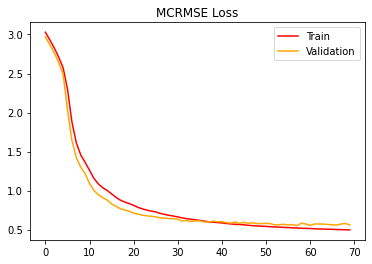

In [21]:
plt.plot(trainer.train_losses, color='red')
plt.plot(trainer.val_losses, color='orange')
plt.title('MCRMSE Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Inference

In [22]:
test_df = pd.read_csv("../input/feedback-prize-english-language-learning/test.csv")
submission = pd.read_csv("../input/feedback-prize-english-language-learning/sample_submission.csv")
df_INNER_JOIN = pd.merge(submission, test_df, left_on='text_id', right_on='text_id', how='inner')
test_df = df_INNER_JOIN
test_df

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions,full_text
0,0000C359D63E,3.0,3.0,3.0,3.0,3.0,3.0,when a person has no experience on a job their...
1,000BAD50D026,3.0,3.0,3.0,3.0,3.0,3.0,Do you think students would benefit from being...
2,00367BB2546B,3.0,3.0,3.0,3.0,3.0,3.0,"Thomas Jefferson once states that ""it is wonde..."


In [23]:
def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [24]:
test_loader = DataLoader(test_ds,
                         batch_size=config['batch_size'],
                         shuffle=False, num_workers=2, pin_memory=True)
predictions = []
for fold in range(1):
    # model = DebertaModel(config)
    # state = torch.load('checkpoint.pt',
    #                    map_location=torch.device('cpu'))
    #model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader, model, device)
    predictions.append(prediction)
    del prediction; gc.collect()
    torch.cuda.empty_cache()
predictions = np.mean(predictions, axis=0)

  0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
predictions 

array([[3.2848706, 3.189334 , 3.4314778, 3.3077087, 3.1745658, 3.2547789],
       [2.5340407, 2.4635665, 2.7702127, 2.5130045, 2.4616733, 2.6247208],
       [3.4932644, 3.4373841, 3.681312 , 3.6722617, 3.2520053, 3.4212346]],
      dtype=float32)

In [26]:
test_df[config['target_cols']] = predictions
test_df

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions,full_text
0,0000C359D63E,3.284871,3.189334,3.431478,3.307709,3.174566,3.254779,when a person has no experience on a job their...
1,000BAD50D026,2.534041,2.463567,2.770213,2.513005,2.461673,2.624721,Do you think students would benefit from being...
2,00367BB2546B,3.493264,3.437384,3.681312,3.672262,3.252005,3.421235,"Thomas Jefferson once states that ""it is wonde..."


In [27]:
import pandas as pd
submission = pd.read_csv('../input/feedback-prize-english-language-learning/sample_submission.csv')
submission

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,3.0,3.0,3.0,3.0,3.0,3.0
1,000BAD50D026,3.0,3.0,3.0,3.0,3.0,3.0
2,00367BB2546B,3.0,3.0,3.0,3.0,3.0,3.0


In [28]:
test = pd.read_csv('../input/feedback-prize-english-language-learning/test.csv')
test

,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."


In [29]:
test_df.drop(columns=['full_text'], inplace=True)
test_df

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,3.284871,3.189334,3.431478,3.307709,3.174566,3.254779
1,000BAD50D026,2.534041,2.463567,2.770213,2.513005,2.461673,2.624721
2,00367BB2546B,3.493264,3.437384,3.681312,3.672262,3.252005,3.421235


In [30]:
test_df.to_csv('submission.csv', index=False)